In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import get_project_root
from src.data_statistical_features import Segment
from src.ml_statistical_features import load_data_as_dataframe

import os

# Load Data

In [2]:
df = load_data_as_dataframe(segment_length=10, overlap_amount=0, hr_threshold=15)

features = df.drop(Segment.get_feature_name_array(), axis='columns')
target = df['informative']
bcg_hr = df['bcg_hr']
ecg_hr = df['ecg_hr']
patient_id = df['patient_id']

# Informative per patient

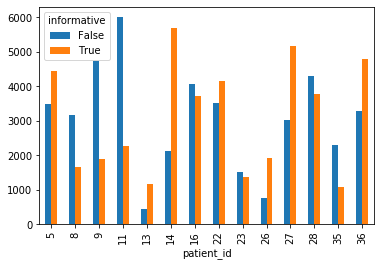

In [3]:
pd.crosstab(df['patient_id'],df['informative']).plot.bar()

# Correlation Heatmap

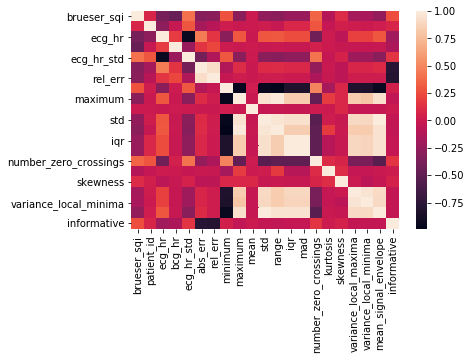

In [4]:
sns.heatmap(df.corr())

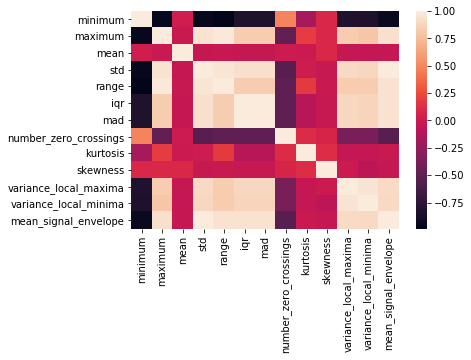

In [5]:
sns.heatmap(features.corr())

# Paarweise geplottet

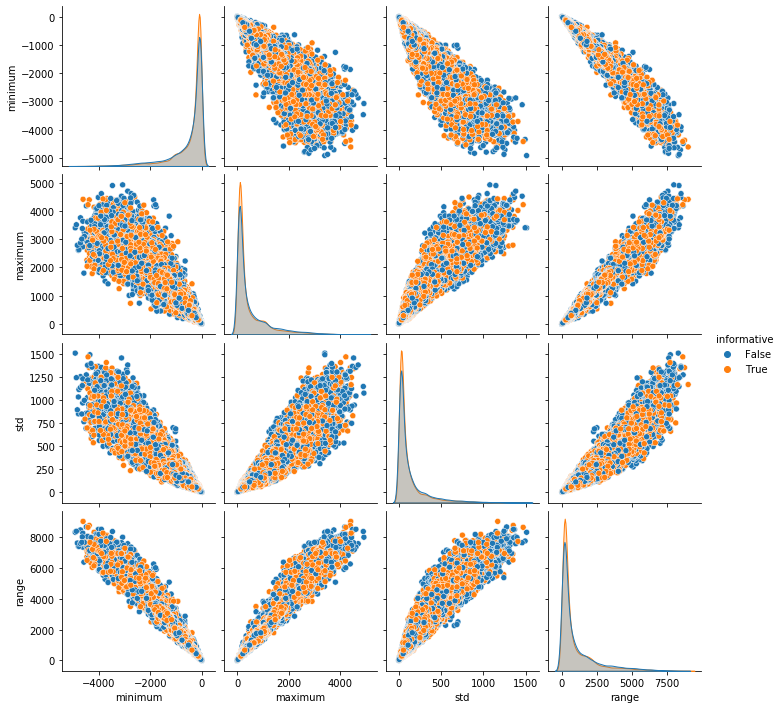

In [6]:
cols = ['minimum', 'maximum', 'std', 'range', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

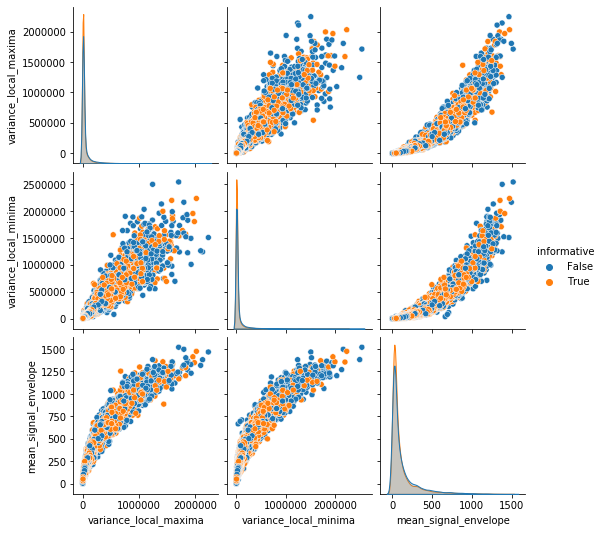

In [7]:
cols = ['variance_local_maxima', 'variance_local_minima', 'mean_signal_envelope', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

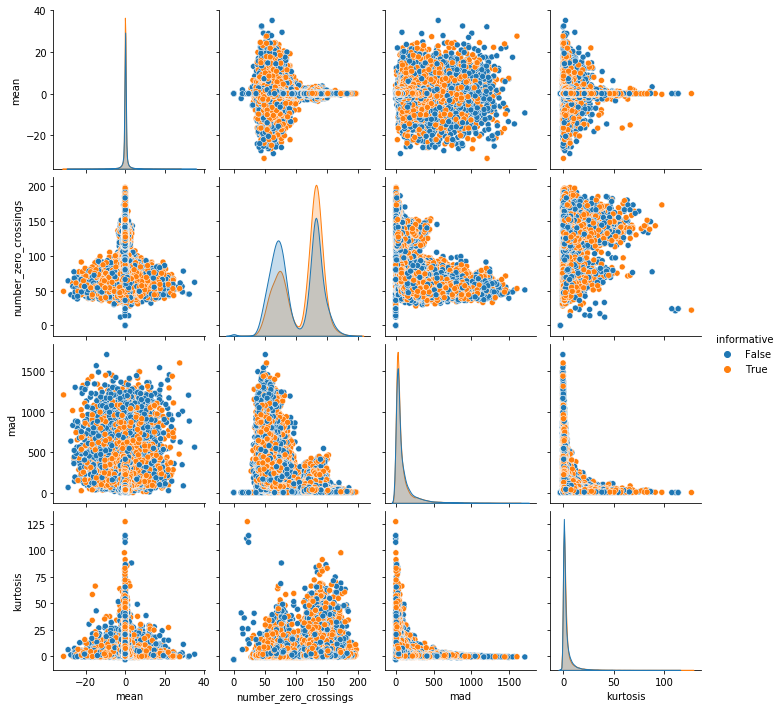

In [8]:
cols = ['mean', 'number_zero_crossings', 'mad', 'kurtosis', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

# Boxplots features

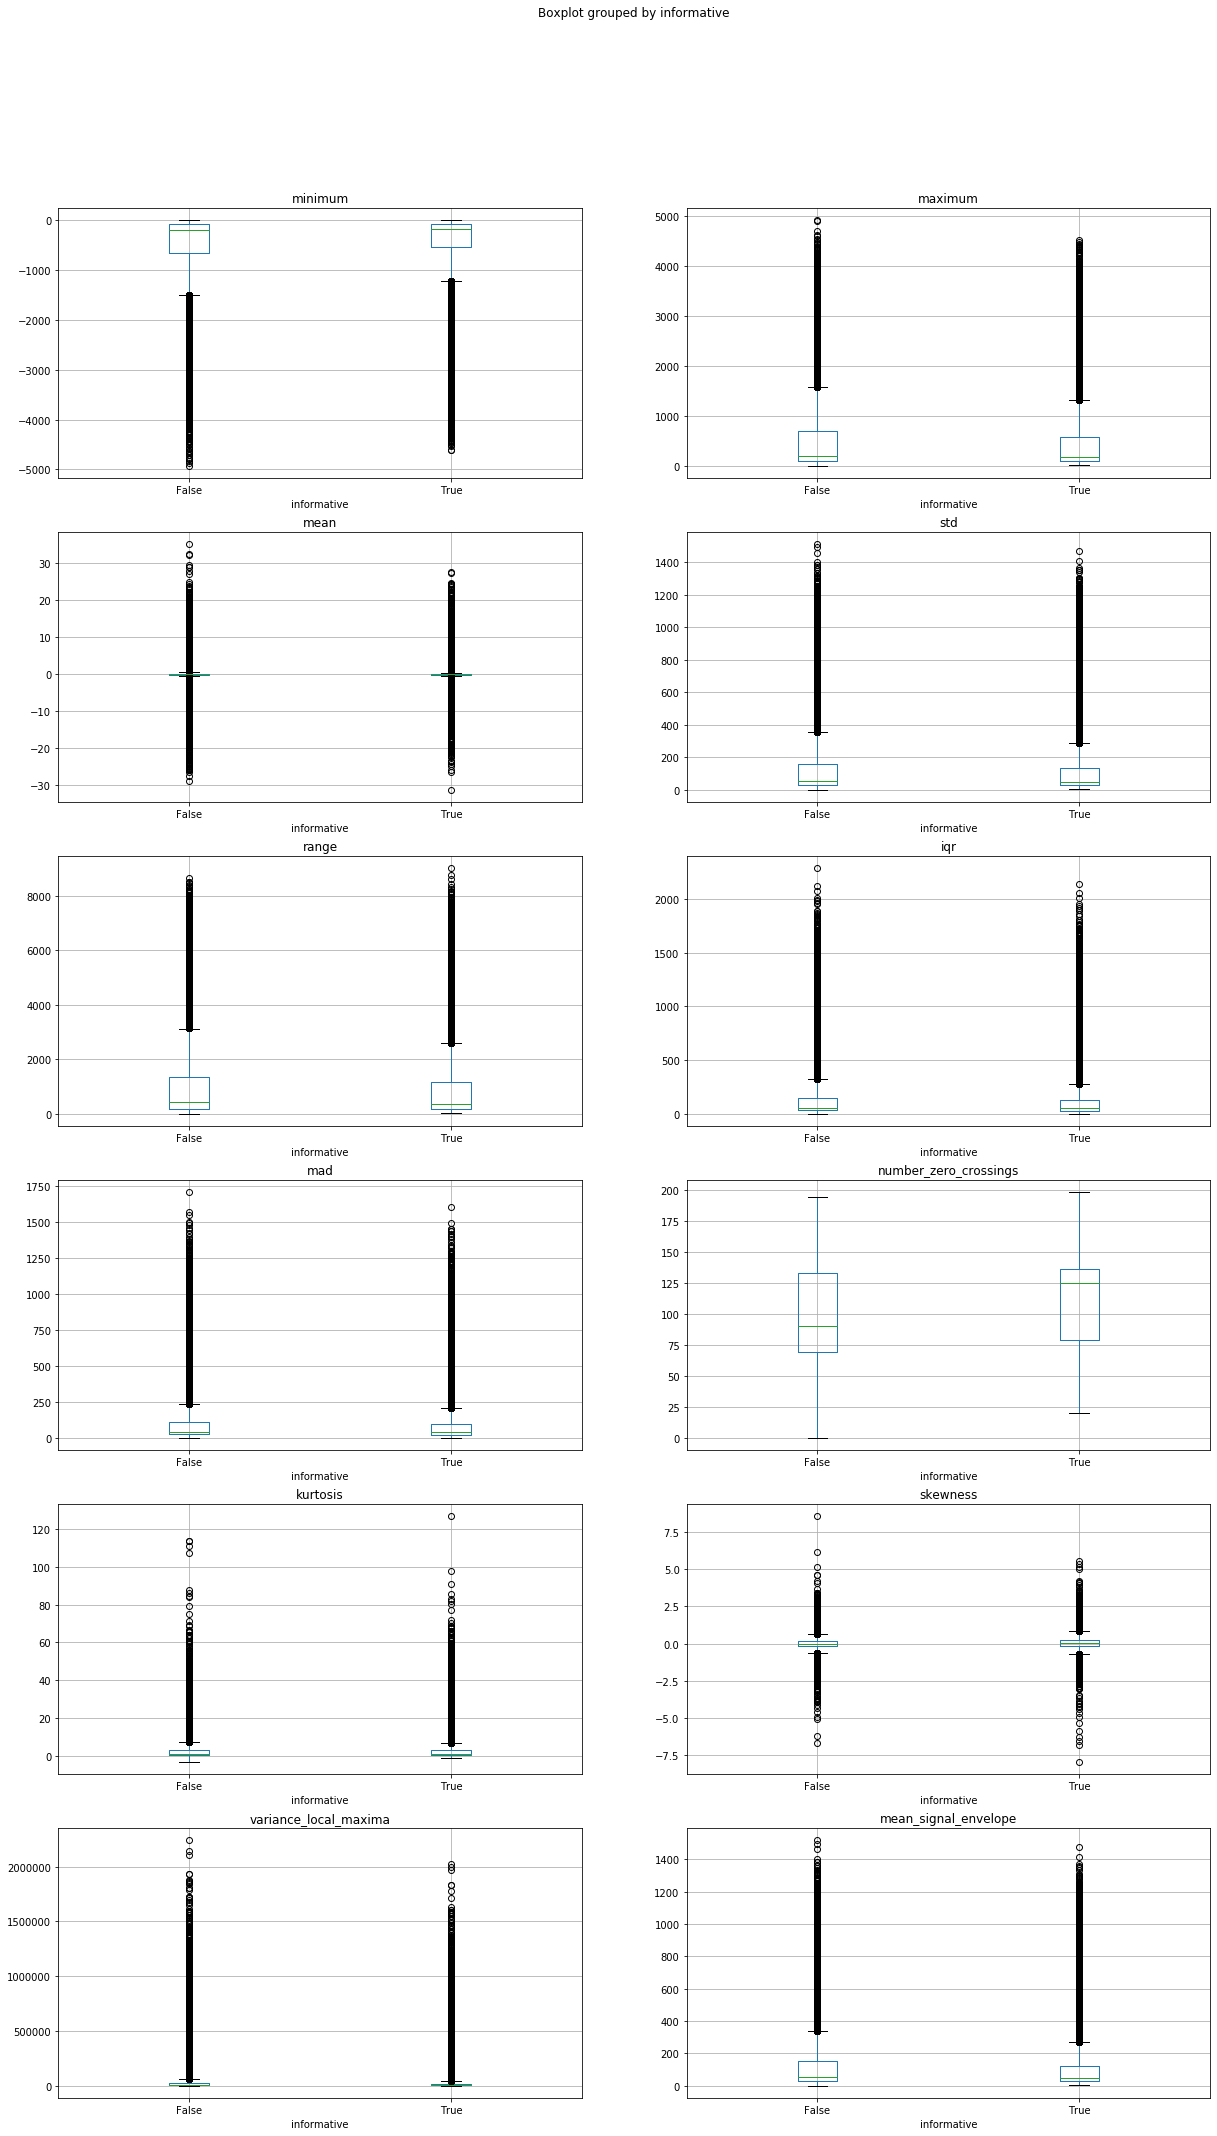

In [9]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,35))

df.boxplot(column=['minimum'],by='informative', ax=axes[0,0])
df.boxplot(column=['maximum'],by='informative', ax=axes[0,1])
df.boxplot(column=['mean'],by='informative', ax=axes[1,0])
df.boxplot(column=['std'],by='informative', ax=axes[1,1])
df.boxplot(column=['range'],by='informative', ax=axes[2,0])
df.boxplot(column=['iqr'],by='informative', ax=axes[2,1])
df.boxplot(column=['mad'],by='informative', ax=axes[3,0])
df.boxplot(column=['number_zero_crossings'],by='informative', ax=axes[3,1])
df.boxplot(column=['kurtosis'],by='informative', ax=axes[4,0])
df.boxplot(column=['skewness'],by='informative', ax=axes[4,1])
df.boxplot(column=['variance_local_maxima'],by='informative', ax=axes[5,0])
df.boxplot(column=['mean_signal_envelope'],by='informative', ax=axes[5,1])
# TODO: deal with inf values


plt.show()

# Fazit
- stark korrelierende Merkmale
- Dimensionsreduktion zur Reduzierung von stark korrelierenden Merkmalen sinnvoll
- keine klare Verteilung von informativ und nicht informativ, große Überlappung

# Einfluss der Merkmale bei Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier


from src.ml_statistical_features import get_patient_split

In [11]:
forest = RandomForestClassifier(random_state=1, class_weight='balanced')
x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.33)

forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

 1) number_zero_crossings          0.113042
 2) skewness                       0.089355
 3) variance_local_maxima          0.078271
 4) kurtosis                       0.076575
 5) variance_local_minima          0.074648
 6) iqr                            0.073858
 7) mad                            0.073547
 8) maximum                        0.073453
 9) minimum                        0.072501
10) range                          0.071030
11) mean                           0.069253
12) mean_signal_envelope           0.067703
13) std                            0.066764


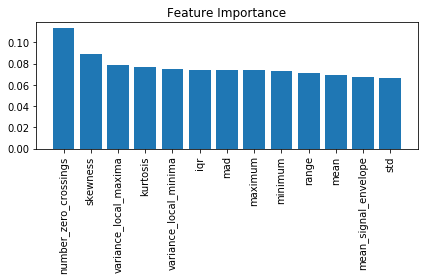

In [12]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features.columns[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()